In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Set constants
IMG_SIZE = 299
BATCH_SIZE = 32
EPOCHS = 10 # try 20
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
# Load Food-101 dataset (TFDS)
dataset_name = "food101"
(ds_train, ds_test), dataset_info = tfds.load(
    dataset_name,
    split=["train", "validation"],
    as_supervised=True,
    # Load the dataset again (it will reuse the already downloaded and prepared data)
    # data_dir='/root/tensorflow_datasets'  # Optional: specify the directory for TFDS
    with_info=True
)

print("Dataset Loaded and Reused:", dataset_name)

# Get class names from dataset metadata
all_class_names = dataset_info.features["label"].names
selected_classes = all_class_names[:10]  # Select the first 10 classes
num_classes = len(selected_classes)

# Convert class names to indices for filtering
selected_class_indices = {i: i for i in range(num_classes)}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.6MKM1P_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.6MKM1P_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
Dataset Loaded and Reused: food101


In [4]:
# Function to filter only the first 10 classes
def filter_classes(image, label):
    return tf.reduce_any(tf.equal(label, list(selected_class_indices.keys())))

ds_train_filtered = ds_train.filter(filter_classes)
ds_test_filtered = ds_test.filter(filter_classes)

# Preprocessing Function (Resizing & Normalisation)
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize to 299x299
    image = preprocess_input(image)  # Apply InceptionV3 preprocessing
    return image, label

# Apply preprocessing
ds_train_preprocessed = ds_train_filtered.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_test_preprocessed = ds_test_filtered.map(preprocess, num_parallel_calls=AUTOTUNE)

# Data Augmentation Function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, label

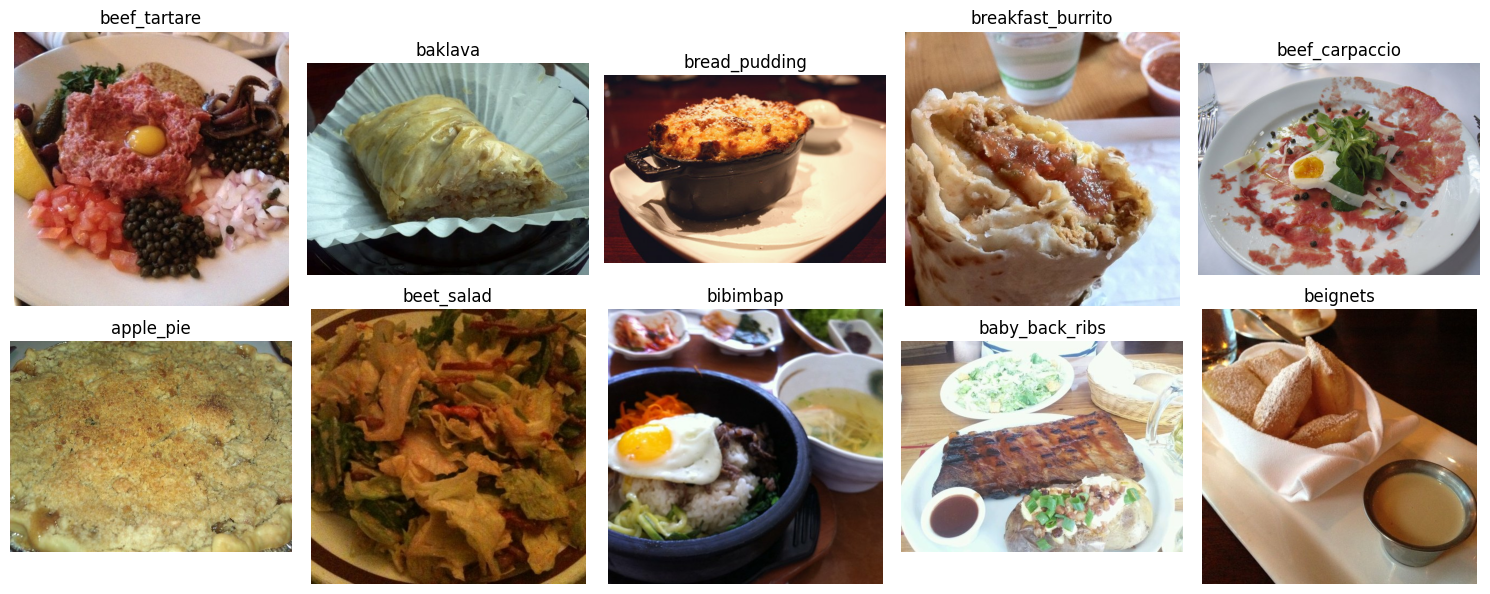

In [5]:
# Create a dictionary to store one sample per class
sample_images = {}

# Iterate through the dataset to collect one image per class
for image, label in ds_train_filtered.take(500):  # Take enough samples to ensure we find all classes
    class_index = label.numpy()
    if class_index not in sample_images:
        sample_images[class_index] = image
    if len(sample_images) == len(selected_class_indices):
        break  # Stop when we have one sample for each of the 10 classes

# Plot images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
axes = axes.flatten()

for i, (class_index, image) in enumerate(sample_images.items()):
    ax = axes[i]
    ax.imshow(image.numpy().astype("uint8"))  # Convert to uint8 for proper display
    class_name = all_class_names[class_index]  # Get class name
    ax.set_title(f"{class_name}")  # Display class name
    ax.axis("off")

plt.tight_layout()
plt.show()


In [6]:
# Apply augmentation to training data
ds_train_final = ds_train_preprocessed.map(augment).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_test_final = ds_test_preprocessed.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Load Pretrained InceptionV3 Model
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base layers


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# Add Custom Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)

output_layer = Dense(num_classes, activation="softmax")(x)

# Create model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train Model (Initial Phase)
start_time = time.time()
history = model.fit(ds_train_final, validation_data=ds_test_final, epochs=EPOCHS)
end_time = time.time()
model.save("food101_Inception_model_.h5")
print("Model saved as: food101_Inception_model_.h5")

# Print runtime
print(f"Training Time: {end_time - start_time:.2f} seconds")


Epoch 1/10
    235/Unknown 40s 98ms/step - accuracy: 0.2196 - loss: 2.2888

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


235/235 ━━━━━━━━━━━━━━━━━━━━ 59s 179ms/step - accuracy: 0.2201 - loss: 2.2874 - val_accuracy: 0.6756 - val_loss: 1.1817
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.5036 - loss: 1.4506 - val_accuracy: 0.7336 - val_loss: 0.8740
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.5906 - loss: 1.2067 - val_accuracy: 0.7576 - val_loss: 0.7565
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.6299 - loss: 1.0721 - val_accuracy: 0.7736 - val_loss: 0.7094
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.6485 - loss: 1.0167 - val_accuracy: 0.7800 - val_loss: 0.6717
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.6742 - loss: 0.9790 - val_accuracy: 0.7864 - val_loss: 0.6488
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.6834 - loss: 0.9142 - val_accuracy: 0.7968 - val_loss: 0.6225
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.6982 - loss: 0.8860 - val_accura

Model saved as: food101_Inception_model_.h5
Training Time: 249.78 seconds


In [8]:
# Fine-Tuning (Unfreeze some layers)
base_model.trainable = True
for layer in base_model.layers[:200]:  # Keep first 200 layers frozen
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train Again (Fine-Tuning)
start_time = time.time()
history_fine_tune = model.fit(ds_train_final, validation_data=ds_test_final, epochs=10)
end_time = time.time()
model.save("food101_Inception_model_finetuning.h5")
print("Model saved as: food101_Inception_model_finetuning.h5")

print(f"Fine-Tuning Time: {end_time - start_time:.2f} seconds")

# Evaluate on Test Set
test_loss, test_acc = model.evaluate(ds_test_final)
print(f"Test Accuracy: {test_acc*100:.4f}%")
print(f"Test Loss: {test_loss:.4f}")


Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 74s 180ms/step - accuracy: 0.5775 - loss: 1.2308 - val_accuracy: 0.8104 - val_loss: 0.5880
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.7251 - loss: 0.8117 - val_accuracy: 0.8288 - val_loss: 0.5139
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.7905 - loss: 0.6358 - val_accuracy: 0.8452 - val_loss: 0.4614
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.8317 - loss: 0.5150 - val_accuracy: 0.8544 - val_loss: 0.4325
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.8524 - loss: 0.4362 - val_accuracy: 0.8580 - val_loss: 0.4144
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.8875 - loss: 0.3404 - val_accuracy: 0.8612 - val_loss: 0.4088
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9154 - loss: 0.2798 - val_accuracy: 0.8668 - val_loss: 0.4034
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9296 - loss: 0.2228 -

Model saved as: food101_Inception_model_finetuning.h5
Fine-Tuning Time: 257.32 seconds
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8726 - loss: 0.4119
Test Accuracy: 87.0800%
Test Loss: 0.4234


In [9]:
# Generate Predictions
y_true, y_pred = [], []
for images, labels in ds_test_final:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━

Classification Report:
                   precision    recall  f1-score   support

        apple_pie       0.77      0.73      0.75       250
   baby_back_ribs       0.91      0.92      0.91       250
          baklava       0.89      0.88      0.88       250
   beef_carpaccio       0.86      0.89      0.87       250
     beef_tartare       0.87      0.86      0.87       250
       beet_salad       0.82      0.83      0.83       250
         beignets       0.90      0.98      0.93       250
         bibimbap       0.97      0.96      0.96       250
    bread_pudding       0.78      0.75      0.76       250
breakfast_burrito       0.93      0.91      0.92       250

         accuracy                           0.87      2500
        macro avg       0.87      0.87      0.87      2500
     weighted avg       0.87      0.87      0.87      2500



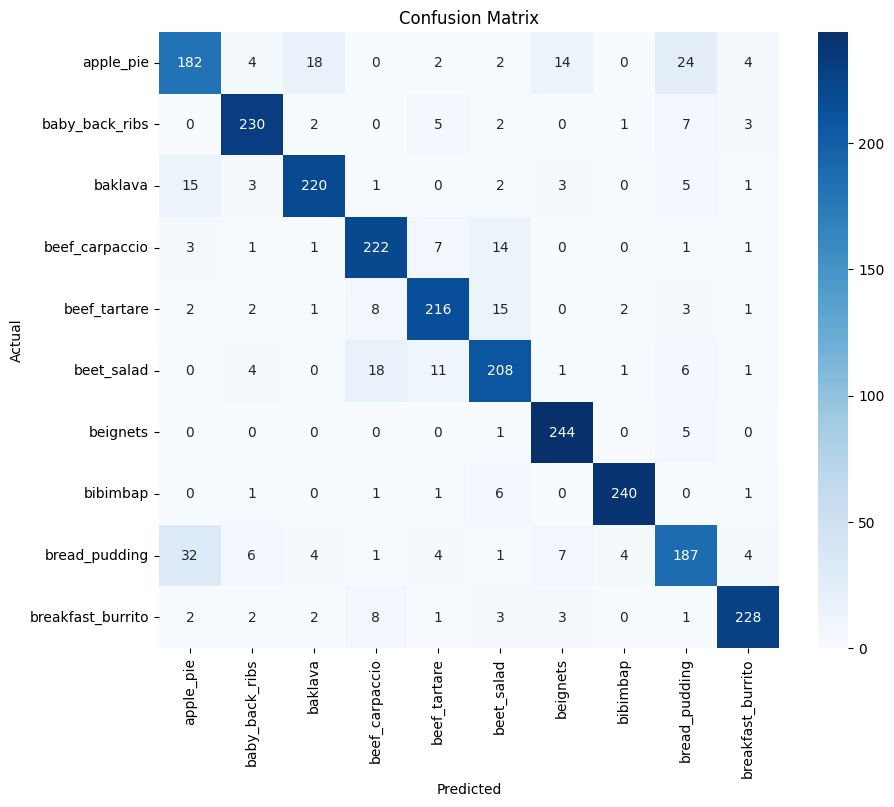

In [10]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=selected_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

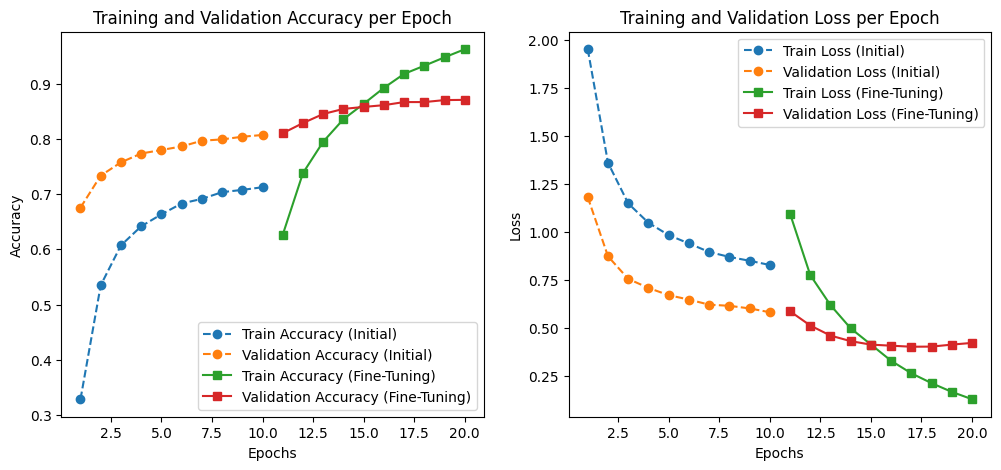

In [11]:
# Extract accuracy and loss for initial training
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract accuracy and loss for fine-tuning
fine_tune_train_acc = history_fine_tune.history['accuracy']
fine_tune_val_acc = history_fine_tune.history['val_accuracy']
fine_tune_train_loss = history_fine_tune.history['loss']
fine_tune_val_loss = history_fine_tune.history['val_loss']

# Create epoch index lists for both phases
epochs_initial = range(1, len(train_acc) + 1)
epochs_finetune = range(len(train_acc) + 1, len(train_acc) + len(fine_tune_train_acc) + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_initial, train_acc, label="Train Accuracy (Initial)", linestyle="dashed", marker="o")
plt.plot(epochs_initial, val_acc, label="Validation Accuracy (Initial)", linestyle="dashed", marker="o")
plt.plot(epochs_finetune, fine_tune_train_acc, label="Train Accuracy (Fine-Tuning)", linestyle="solid", marker="s")
plt.plot(epochs_finetune, fine_tune_val_acc, label="Validation Accuracy (Fine-Tuning)", linestyle="solid", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy per Epoch")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_initial, train_loss, label="Train Loss (Initial)", linestyle="dashed", marker="o")
plt.plot(epochs_initial, val_loss, label="Validation Loss (Initial)", linestyle="dashed", marker="o")
plt.plot(epochs_finetune, fine_tune_train_loss, label="Train Loss (Fine-Tuning)", linestyle="solid", marker="s")
plt.plot(epochs_finetune, fine_tune_val_loss, label="Validation Loss (Fine-Tuning)", linestyle="solid", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss per Epoch")

plt.show()


In [12]:
# Check the number of examples in the training and test datasets
train_size = len(ds_train)
test_size = len(ds_test)

print(f"Training set size: {train_size}")
print(f"Test set size: {test_size}")

Training set size: 75750
Test set size: 25250


In [13]:
# Check the shape of a batch from the train and test datasets
for image, label in ds_train.take(1):  # Take one batch from the train set
    print("Train batch shape:", image.shape)

for image, label in ds_test.take(1):  # Take one batch from the test set
    print("Test batch shape:", image.shape)


Train batch shape: (512, 512, 3)
Test batch shape: (382, 512, 3)


In [14]:
# Check the number of batches (steps per epoch)
steps_per_epoch = len(ds_train)  # Number of batches in the train dataset
validation_steps = len(ds_test)  # Number of batches in the test dataset
print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 75750
Validation steps: 25250


In [15]:
print(dataset_info)


tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir=PosixGPath('/tmp/tmpvy8xvfqetfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examp